<a href="https://colab.research.google.com/github/alex-nuclearboy/goit-python-ds-project/blob/main/toxic_bert_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT model trained on the `train_data_cleaned` dataset

In [1]:
!pip install torch
!pip install transformers

In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
# Download the dataset from Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to a clean dataset
dataset_path = '/content/drive/My Drive/toxic_comments_data/train_data_cleaned.csv'

# Load the dataset into a DataFrame
df_train = pd.read_csv(dataset_path)

df_train.head()

Mounted at /content/drive


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,token_count
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0,54
1,000103f0d9cfb60f,daww he matches this background colour im seem...,0,0,0,0,0,0,20
2,000113f07ec002fd,"hey man, im really not trying to edit war. its...",0,0,0,0,0,0,48
3,0001b41b1c6bb37e,more i cant make any real suggestions on impro...,0,0,0,0,0,0,119
4,0001d958c54c6e35,"you, sir, are my hero. any chance you remember...",0,0,0,0,0,0,17


In [4]:
column_labels = df_train.columns.tolist()[2:8]
df_train[column_labels].sum().sort_values(ascending=False)

,0
toxic,15294
obscene,8449
insult,7877
severe_toxic,1595
identity_hate,1405
threat,478


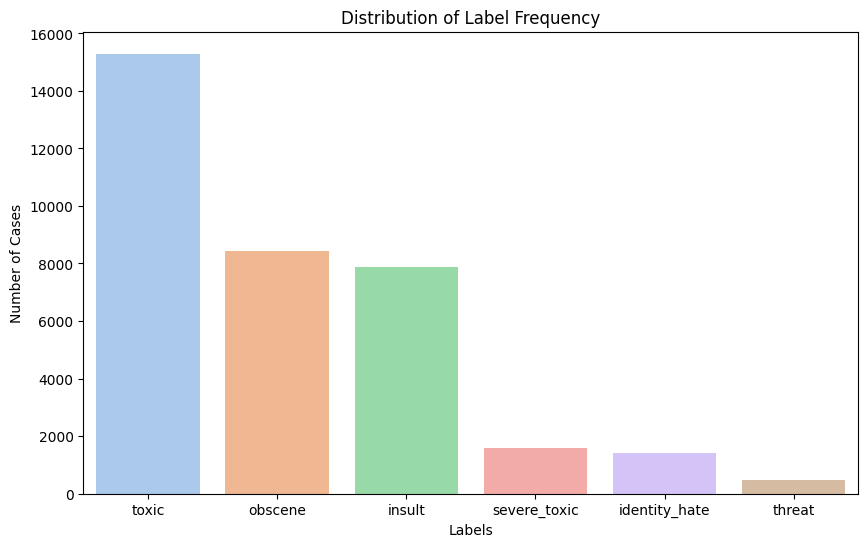

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizing the class distribution of the 'label' column
label_counts = df_train[column_labels].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))

ax = sns.barplot(x=label_counts.index, y=label_counts.values, hue=label_counts.index, palette='pastel', legend=False)

# Add labels and title to the plot
plt.xlabel('Labels')
plt.ylabel('Number of Cases')
plt.title('Distribution of Label Frequency')

plt.show()

In [6]:
# Create subsets based on toxic and non-toxic comments
train_toxic = df_train[df_train[column_labels].sum(axis=1) > 0]
train_clean = df_train[df_train[column_labels].sum(axis=1) == 0]

# Number of toxic and non-toxic comments
num_toxic = len(train_toxic)
num_clean = len(train_clean)

print(f"Number of toxic comments: {num_toxic}")
print(f"Number of non-toxic comments: {num_clean}")

Number of toxic comments: 16225
Number of non-toxic comments: 143346


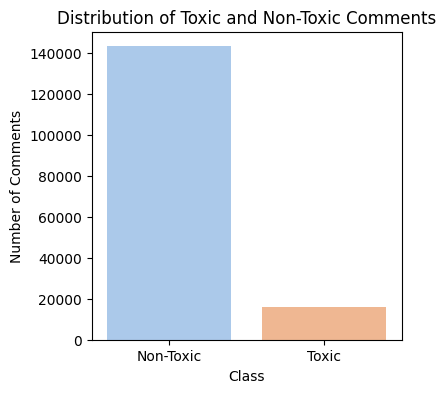

In [7]:
# Create a DataFrame for visualization
plot_data = pd.DataFrame(
    {'Class': ['Non-Toxic', 'Toxic'], 'Count': [num_clean, num_toxic]})

plt.figure(figsize=(4, 4))

ax = sns.barplot(x='Class', y='Count', data=plot_data, hue='Class', palette='pastel', legend=False)


# Add labels and title to the plot
plt.xlabel('Class')
plt.ylabel('Number of Comments')
plt.title('Distribution of Toxic and Non-Toxic Comments')

plt.show()

The dataset is highly imbalanced, with almost nine times more non-toxic comments than toxic ones. This can negatively impact the model's learning by causing it to favor the "non-toxic" class.

To handle this, a new training set can be created where the number of toxic comments stays the same, and 16,225 non-toxic comments will be randomly sampled and added to the training set. This will help create a more balanced dataset for the model to learn from.

In [8]:
# Randomly sample 16225 non-toxic comments
train_clean_sampled = train_clean.sample(n=16225, random_state=42)

# Combine the toxic and sampled clean comments
df_combined = pd.concat([train_toxic, train_clean_sampled], axis=0)

# Shuffle the data
df_combined = df_combined.sample(frac=1, random_state=42)

In [9]:
print(f"Shape of the toxic comments dataset: {train_toxic.shape}")
print(f"Shape of the sampled non-toxic comments dataset: {train_clean_sampled.shape}")
print(f"Shape of the combined balanced dataset: {df_combined.shape}")

Shape of the toxic comments dataset: (16225, 9)
Shape of the sampled non-toxic comments dataset: (16225, 9)
Shape of the combined balanced dataset: (32450, 9)


The resulting dataset consists of 16,225 toxic comments and 16,225 non-toxic comments, making a total of 32,450 comments. This is a balanced dataset, ensuring that both classes are represented equally, which can help improve the model's performance in learning to classify comments accurately.

In [10]:
# Split data into training and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(
    df_combined['comment_text'],
    df_combined.iloc[:, 2:8],
    test_size=0.20,
    random_state=42
)

In [11]:
print(f'Training data shape: {train_data.shape}')
print(f'Training labels shape: {train_labels.shape}')
print(f'Validation data shape: {val_data.shape}')
print(f'Validation labels shape: {val_labels.shape}')

Training data shape: (25960,)
Training labels shape: (25960, 6)
Validation data shape: (6490,)
Validation labels shape: (6490, 6)


In [12]:
# Token and Encode Function
def tokenize_and_encode(tokenizer, comments, labels, max_length=512):
	# Initialize empty lists to store tokenized inputs and attention masks
	input_ids = []
	attention_masks = []

	# Iterate through each comment in the 'comments' list
	for comment in comments:

		# Tokenize and encode the comment using the ALBERT tokenizer
		encoded_dict = tokenizer.encode_plus(
			comment,

			# Add special tokens like [CLS] and [SEP]
			add_special_tokens=True,

			# Truncate or pad the comment to 'max_length'
			max_length=max_length,
      padding='max_length',
      truncation=True,

			# Return attention mask to mask padded tokens
			return_attention_mask=True,

			# Return PyTorch tensors
			return_tensors='pt'
		)

		# Append the tokenized input and attention mask to their respective lists
		input_ids.append(encoded_dict['input_ids'])
		attention_masks.append(encoded_dict['attention_mask'])

	# Concatenate the tokenized inputs and attention masks into tensors
	input_ids = torch.cat(input_ids, dim=0)
	attention_masks = torch.cat(attention_masks, dim=0)

	# Convert the labels to a PyTorch tensor with the data type float32
	labels = torch.tensor(labels, dtype=torch.float32)

	# Return the tokenized inputs, attention masks, and labels as PyTorch tensors
	return input_ids, attention_masks, labels

In [13]:
# Token Initialization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [14]:
# Model Initialization
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# Check for NaN values in train_data
print("NaN values in train_data:")
print(train_data.isnull().sum())

# Drop rows with NaN values in train_data
train_data_cleaned = train_data.dropna()

# Filter train_labels to match the cleaned train_data
train_labels_cleaned = train_labels.loc[train_data_cleaned.index]

# Recheck for NaN values after cleaning
print("NaN values in train_data_cleaned:")
print(train_data_cleaned.isnull().sum())
print("NaN values in train_labels_cleaned:")
print(train_labels_cleaned.isnull().sum())

NaN values in train_data:
0
NaN values in train_data_cleaned:
0
NaN values in train_labels_cleaned:
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [16]:
# Check for NaN values in val_data
print("NaN values in val_data:")
print(val_data.isnull().sum())

# Drop rows with NaN values in val_data
val_data_cleaned = val_data.dropna()

# Filter val_labels to match the cleaned val_data
val_labels_cleaned = val_labels.loc[val_data_cleaned.index]

# Recheck for NaN values after cleaning
print("NaN values in val_data_cleaned:")
print(val_data_cleaned.isnull().sum())
print("NaN values in val_labels_cleaned:")
print(val_labels_cleaned.isnull().sum())

NaN values in val_data:
1
NaN values in val_data_cleaned:
0
NaN values in val_labels_cleaned:
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [17]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

In [18]:
# Tokenize and Encode the comments and labels for the training set
input_ids, attention_masks, labels = tokenize_and_encode(
    tokenizer,
    train_data_cleaned,
    train_labels_cleaned.values
)

In [19]:
print('Training Comments :',train_data_cleaned.shape)
print('Input Ids         :',input_ids.shape)
print('Attention Mask    :',attention_masks.shape)
print('Labels            :',labels.shape)

Training Comments : (25960,)
Input Ids         : torch.Size([25960, 512])
Attention Mask    : torch.Size([25960, 512])
Labels            : torch.Size([25960, 6])


In [20]:
# Tokenize and Encode the comments and labels for the validation set
val_input_ids, val_attention_masks, val_labels = tokenize_and_encode(
    tokenizer,
    val_data_cleaned,
    val_labels_cleaned.values
)

In [21]:
from torch.utils.data import DataLoader, TensorDataset

# Creating DataLoader
batch_size = 8

# Training set
train_dataset = TensorDataset(input_ids, attention_masks, labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Validation set
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [22]:
from transformers import AdamW

# Optimizer setup
optimizer = AdamW(model.parameters(), lr=2e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [23]:
# Function to train the model
def train_model(model, train_loader, optimizer, device, num_epochs):
    # Loop through the specified number of epochs
    for epoch in range(num_epochs):
        # Set the model to training mode
        model.train()
        # Initialize total loss for the current epoch
        total_loss = 0

        # Loop through the batches in the training data
        for batch in train_loader:
            input_ids, attention_mask, labels = [t.to(device) for t in batch]

            optimizer.zero_grad() # Clear the gradients from the previous step to prevent accumulation

            outputs = model(
                input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        model.eval()  # Set the model to evaluation mode
        val_loss = 0

        # Disable gradient computation during validation
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [
                    t.to(device) for t in batch]

                outputs = model(
                    input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                val_loss += loss.item()
        # Print the average loss for the current epoch
        print(
            f'Epoch {epoch+1}, Training Loss: {total_loss/len(train_loader)},Validation loss:{val_loss/len(val_loader)}')

In [24]:
# Call the function to train the model
train_model(model, train_loader, optimizer, device, num_epochs=3)

Epoch 1, Training Loss: 0.17177406169505696,Validation loss:0.14361258237760313
Epoch 2, Training Loss: 0.1284179255133136,Validation loss:0.15100170824254674
Epoch 3, Training Loss: 0.1032608607976564,Validation loss:0.14841154415052604


## Test the model on the `test_cleaned` dataset

In [25]:
# Path to a clean test dataset
test_dataset_path = '/content/drive/My Drive/toxic_comments_data/test_cleaned.csv'

# Load the dataset into a DataFrame
df_test = pd.read_csv(test_dataset_path)


df_test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0001ea8717f6de06,thank you for understanding. i think very high...,0,0,0,0,0,0
1,000247e83dcc1211,dear god this site is horrible.,0,0,0,0,0,0
2,0002f87b16116a7f,somebody will invariably try to add religion r...,0,0,0,0,0,0
3,0003e1cccfd5a40a,it says it right there that it is a type. the ...,0,0,0,0,0,0
4,00059ace3e3e9a53,"before adding a new product to the list, make ...",0,0,0,0,0,0


In [26]:
# Extract the comment texts and labels from the test DataFrame
test_data = df_test['comment_text']
test_labels = df_test.iloc[:, 2:]

In [27]:
print(f'Test data shape: {test_data.shape}')
print(f'Test labels shape: {test_labels.shape}')

Test data shape: (63978,)
Test labels shape: (63978, 6)


In [28]:
# Check for NaN values in test_data
print("NaN values in test_data:")
print(test_data.isnull().sum())

# Drop rows with NaN values in test_data
test_data_cleaned = test_data.dropna()

# Filter test_labels to match the cleaned test_data
test_labels_cleaned = test_labels.loc[test_data_cleaned.index]

# Recheck for NaN values after cleaning
print("NaN values in test_data_cleaned:")
print(test_data_cleaned.isnull().sum())
print("NaN values in test_labels_cleaned:")
print(test_labels_cleaned.isnull().sum())

NaN values in test_data:
501
NaN values in test_data_cleaned:
0
NaN values in test_labels_cleaned:
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [29]:
# Tokenize and Encode the comments and labels for the test set
test_input_ids, test_attention_masks, test_labels = tokenize_and_encode(
    tokenizer,
    test_data_cleaned,
    test_labels_cleaned.values
)

In [30]:
# Creating DataLoader for the testing dataset
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [31]:
# Evaluate the model
def evaluate_model(model, test_loader, device, label_names):
    model.eval()  # Set the model to evaluation mode

    true_labels = []  # List to store true labels
    predicted_probs = []  # List to store predicted probabilities

    # Disable gradient computation for evaluation
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [t.to(device) for t in batch]

            # Get model's predictions
            outputs = model(input_ids, attention_mask=attention_mask)
            # Apply sigmoid for multilabel classification to get probabilities
            predicted_probs_batch = torch.sigmoid(outputs.logits)
            predicted_probs.append(predicted_probs_batch.cpu().numpy())

            # Store true labels for later evaluation
            true_labels_batch = labels.cpu().numpy()
            true_labels.append(true_labels_batch)

    # Combine predictions and labels for evaluation
    true_labels = np.concatenate(true_labels, axis=0)
    predicted_probs = np.concatenate(predicted_probs, axis=0)

    # Apply threshold for binary classification (0.5 is commonly used)
    predicted_labels = (predicted_probs > 0.5).astype(int)

    # Calculate evaluation metrics for overall performance
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='micro')
    recall = recall_score(true_labels, predicted_labels, average='micro')
    f1 = f1_score(true_labels, predicted_labels, average='micro')

    # Calculate evaluation metrics for each label (class-specific)
    precision_per_label = precision_score(true_labels, predicted_labels, average=None)
    recall_per_label = recall_score(true_labels, predicted_labels, average=None)
    f1_per_label = f1_score(true_labels, predicted_labels, average=None)

    # Print the overall evaluation metrics
    print(f'Overall Accuracy: {accuracy:.4f}')
    print(f'Overall Precision: {precision:.4f}')
    print(f'Overall Recall: {recall:.4f}')
    print(f'Overall F1 Score: {f1:.4f}')

    # Print evaluation metrics for each label
    print("\nEvaluation per label:")
    for i, label in enumerate(label_names):
        print(f'{label}:')
        print(f'  Precision: {precision_per_label[i]:.4f}')
        print(f'  Recall: {recall_per_label[i]:.4f}')
        print(f'  F1 Score: {f1_per_label[i]:.4f}')


In [32]:
# List of labels in the dataset
label_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Call the function to evaluate the model on the test data
evaluate_model(model, test_loader, device, label_names)

Overall Accuracy: 0.8001
Overall Precision: 0.4606
Overall Recall: 0.8355
Overall F1 Score: 0.5939

Evaluation per label:
toxic:
  Precision: 0.3907
  Recall: 0.9691
  F1 Score: 0.5569
severe_toxic:
  Precision: 0.2614
  Recall: 0.4573
  F1 Score: 0.3327
obscene:
  Precision: 0.5645
  Recall: 0.8013
  F1 Score: 0.6624
threat:
  Precision: 0.4415
  Recall: 0.3971
  F1 Score: 0.4181
insult:
  Precision: 0.6355
  Recall: 0.7291
  F1 Score: 0.6791
identity_hate:
  Precision: 0.4233
  Recall: 0.7040
  F1 Score: 0.5287


## Save the model

In [33]:
import os

# Define the output directory for the model and tokenizer
output_dir = "/content/drive/My Drive/toxic_bert_model_balanced"

# Create the directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the model's state dictionary and configuration
model.save_pretrained(output_dir)

# Save the tokenizer's configuration and vocabulary
tokenizer.save_pretrained(output_dir)

# Save the model weights separately
torch.save(model.state_dict(), os.path.join(output_dir, 'toxic_bert_model_balanced_weights.pth'))

In [34]:
from safetensors.torch import save_file

# Save the model in safetensors format
save_file(model.state_dict(), os.path.join(output_dir, 'model.safetensors'))

In [35]:
import pickle

with open(os.path.join(output_dir, 'toxic_bert_model_balanced.pkl'), 'wb') as fh:
    pickle.dump(model, fh)